# Literature

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from literature revisions and literature items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/literature_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/literature.csv')

In [3]:
print("Number of Revisions in Literature Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Literature Dataset")
print(items.shape)

Number of Revisions in Literature Dataset
(620265, 12)
Number of Wikidata Items in Literature Dataset
(196536, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(620265, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    196056.000000
mean          3.145729
std           8.408573
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         456.000000
Name: qid, dtype: float64

In [15]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [16]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
66831
Items with No of Edits = 2
64939
Items with No of Edits = 3
20478
Items with No of Edits = 4
17098
Items with No of Edits = 5
6373
Items with No of Edits <= 5
175719


In [17]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [18]:
df_editscount.shape

(20337, 2)

In [19]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [20]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [23]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [21]:
print(df_editscount.head())
print(df_editscount[df_editscount['qid'] == 'Q4115189'])
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])

         qid  editscount
0     Q22686         456
1    Q131674         350
2     Q28614         338
3  Q27524867         334
4  Q27530659         333
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []


In [22]:
print("Number of Revisions in Literature Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Literature Dataset after Data Cleaning")
literature_items = rev['qid'].value_counts()
print(literature_items.shape)

Number of Revisions in Literature Dataset after Data Cleaning
(258339, 10)
Number of Wikidata Items in Literature Dataset after Data Cleaning
(20337,)


# Descriptive Statistics

In [23]:
print(literature_items.describe().astype(int))

count    20337
mean        12
std         23
min          6
25%          7
50%          9
75%         12
max        456
Name: qid, dtype: int32


In [24]:
# Converting a series to a dataframe
l_items = pd.DataFrame({'type':literature_items.index, 'count':literature_items.values})

In [25]:
# Items between the median and 75th percentile
print(l_items[(l_items['count'] >= 9) & (l_items['count'] < 12)])
# Items in the top 25% of the dataset
print(l_items[l_items['count'] >= 12])
# Items below median that is items that fall in the fist 50%
print(l_items[l_items['count'] < 9])
# Items that form the low 25% of the dataset
print(l_items[l_items['count'] < 7])
# Items that are part of 75% of the dataset
print(l_items[l_items['count'] < 12])

            type  count
5907     Q445807     11
5908   Q19288563     11
5909     Q298945     11
5910   Q18527160     11
5911    Q7344015     11
...          ...    ...
10626  Q19764893      9
10627  Q16750520      9
10628    Q696026      9
10629  Q22031826      9
10630  Q27653591      9

[4724 rows x 2 columns]
           type  count
0        Q22686    456
1       Q131674    350
2        Q28614    338
3     Q27524867    334
4     Q27530659    333
...         ...    ...
5902  Q24261328     12
5903  Q27996900     12
5904  Q21092396     12
5905    Q237740     12
5906  Q27901822     12

[5907 rows x 2 columns]
            type  count
10631   Q3063901      8
10632   Q2708943      8
10633  Q24261401      8
10634    Q466595      8
10635  Q12360267      8
...          ...    ...
20332  Q27635935      6
20333   Q3307158      6
20334  Q12731091      6
20335  Q27990199      6
20336   Q3205142      6

[9706 rows x 2 columns]
            type  count
15795    Q709077      6
15796   Q4539904      6
1

# Statistics for Proxies

In [28]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [29]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

          count
type           
add      101778
create   100787
update    38361
remove     8433
set        6805
revert      987
undo        552
merge       330
restore     283
protect      23


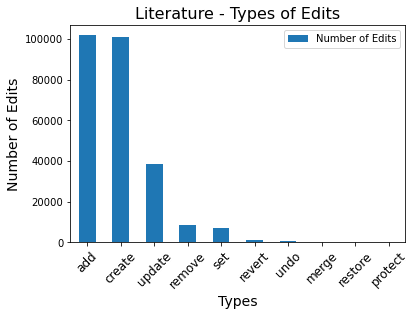

In [30]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Literature - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [31]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

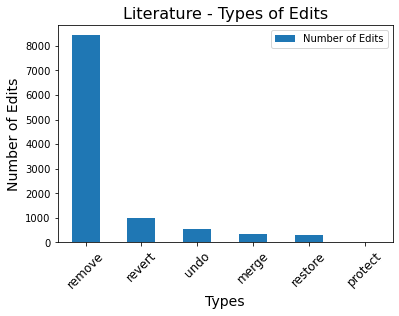

In [32]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Literature - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [33]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
revert     987
undo       552
merge      330
restore    283
protect     23


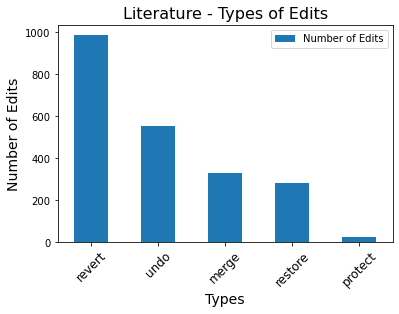

In [34]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Literature - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [35]:
no_of_edits = literature_items.to_numpy()

(array([1.3303e+04, 3.3520e+03, 1.8530e+03, 7.6900e+02, 3.8000e+02,
        1.7600e+02, 1.2600e+02, 7.5000e+01, 5.9000e+01, 2.2000e+01,
        1.6000e+01, 9.0000e+00, 1.2000e+01, 9.0000e+00, 7.0000e+00,
        7.0000e+00, 1.3000e+01, 2.0000e+00, 1.0000e+00, 5.0000e+00,
        7.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 5.0000e+00, 1.7000e+01, 3.6000e+01, 1.8000e+01,
        1.3000e+01, 5.0000e+00, 2.0000e+00, 1.00

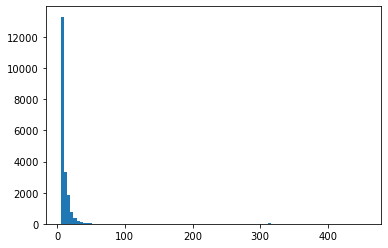

In [36]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

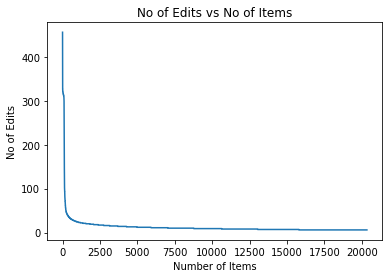

In [37]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [38]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [39]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [40]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [41]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [42]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [43]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [44]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [45]:
proxies = proxies.reset_index()

In [46]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [47]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [48]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [49]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [50]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [51]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000
mean,0.048532,0.016227,0.027143,0.013916,0.001131,0.414663,12.702906,3.170772
std,0.419052,0.132801,0.392508,0.171060,0.035044,1.025207,23.859250,2.517542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,4.000000
max,19.000000,3.000000,31.000000,8.000000,2.000000,32.000000,456.000000,122.000000


Text(0, 0.5, 'No of Edits')

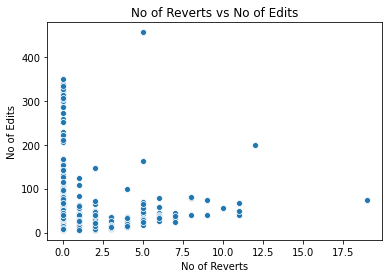

In [52]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

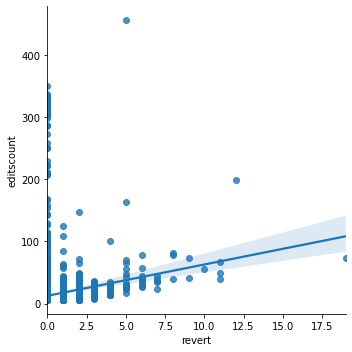

In [53]:
sns.lmplot(x="revert", y="editscount", data=proxies)

In [54]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.043284,0.242223,0.438530,0.307676,0.134689,0.088588,0.376499
merge,0.043284,1.000000,0.075511,0.044176,0.038322,0.112746,0.014899,0.102905
undo,0.242223,0.075511,1.000000,0.240455,0.140768,0.191990,0.125553,0.355794
restore,0.438530,0.044176,0.240455,1.000000,0.358308,0.175431,0.111244,0.275491
protect,0.307676,0.038322,0.140768,0.358308,1.000000,0.119711,0.054921,0.149416
remove,0.134689,0.112746,0.191990,0.175431,0.119711,1.000000,0.127148,0.338080
editscount,0.088588,0.014899,0.125553,0.111244,0.054921,0.127148,1.000000,0.210123
userscount,0.376499,0.102905,0.355794,0.275491,0.149416,0.338080,0.210123,1.000000


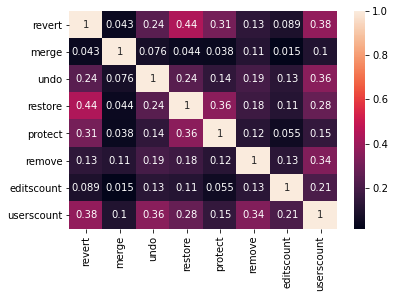

In [55]:
sns.heatmap(corr_matrix, annot=True)

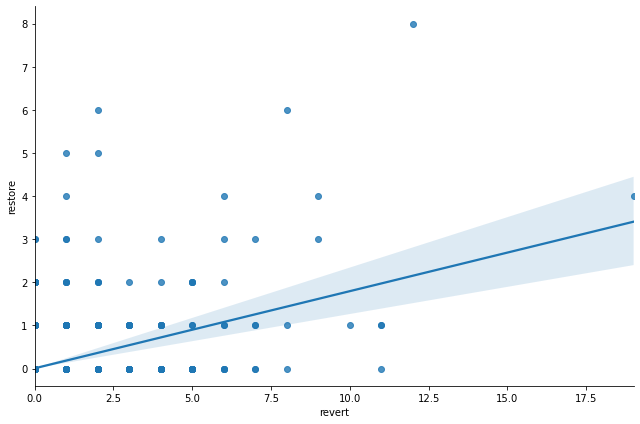

In [56]:
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

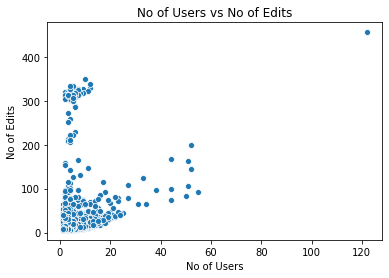

In [57]:
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

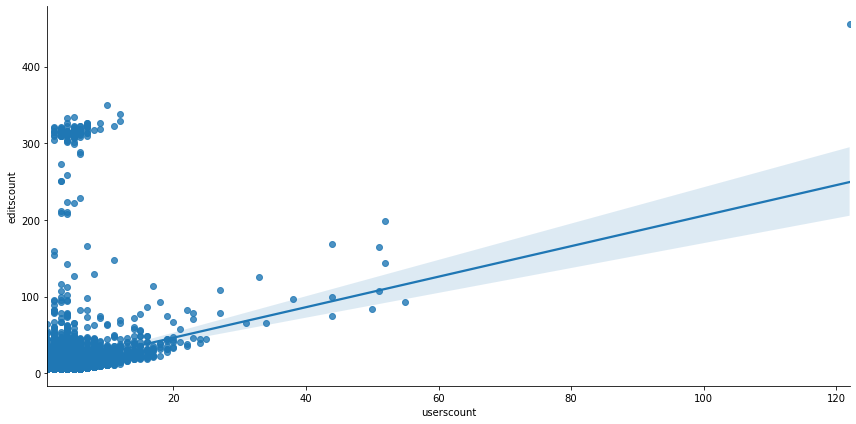

In [58]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=2)

In [59]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [60]:
proxies.shape

(5411, 9)

In [61]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
45,Q2161317,0,0,0,0,0,1,6,2
49,Q2163773,0,0,0,0,0,2,6,3
53,Q2168474,0,0,0,0,0,3,8,2
55,Q2171566,0,0,0,0,0,1,9,5
67,Q2196866,0,0,0,0,0,1,21,2
...,...,...,...,...,...,...,...,...,...
20271,Q28076599,0,0,0,0,0,1,20,5
20310,Q28086637,0,0,0,0,0,1,21,1
20324,Q28089618,0,0,0,0,0,1,9,2
20326,Q28090273,0,0,0,0,0,3,40,1


In [62]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [63]:
proxies_without_remove.shape

(1073, 9)

In [64]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.282771,0.118155,0.329347,0.278720,0.091680,0.183388,0.365278
merge,-0.282771,1.000000,-0.093148,-0.167209,-0.038321,0.034578,-0.076108,-0.153107
undo,0.118155,-0.093148,1.000000,0.155379,0.106321,0.267313,0.325834,0.416044
restore,0.329347,-0.167209,0.155379,1.000000,0.334632,0.220204,0.274892,0.256795
protect,0.278720,-0.038321,0.106321,0.334632,1.000000,0.177046,0.135737,0.160779
remove,0.091680,0.034578,0.267313,0.220204,0.177046,1.000000,0.414884,0.483845
editscount,0.183388,-0.076108,0.325834,0.274892,0.135737,0.414884,1.000000,0.530975
userscount,0.365278,-0.153107,0.416044,0.256795,0.160779,0.483845,0.530975,1.000000


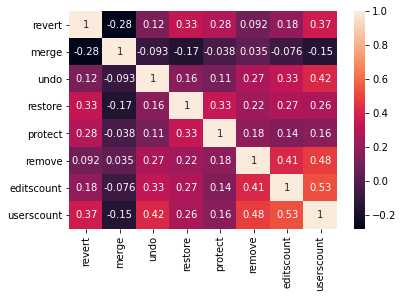

In [65]:
sns.heatmap(corr, annot=True)

# Top 20 

## Top 20 Reverts

In [66]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [67]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
898,Q5878,19,0,3,4,0,0,74,9
904,Q6294,12,0,3,8,0,14,199,52
814,Q1203,11,0,2,1,0,0,67,20
885,Q5588,11,0,1,1,1,1,39,14
1272,Q33977,11,0,0,0,1,2,49,15
757,Q23,10,0,1,1,0,8,55,15
1114,Q15975,9,1,1,3,1,0,41,13
1122,Q16867,9,0,4,4,0,2,74,19
758,Q42,8,0,6,6,1,11,78,23
893,Q5686,8,0,1,1,0,4,82,22


In [68]:
revert_item_labels = ['Gabriel García Márquez', 'Hillary Clinton', 'John Lennon', 'Frida Kahlo', 'Jules Verne',
                     'George Washington', 'Montesquieu', 'Edgar Allan Poe', 'Douglas Adams', 'Charles Dickens', 
                     'Homer', 'Bill Clinton', 'Karl Marx', 'Immanuel Kant', 'Thales', 
                     'Adam Sandler', 'Molière', 'Mahatma Gandhi', 'Antoine de Saint-Exupéry', 'Che Guevara']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [69]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
898,Q5878,Gabriel García Márquez,19,0,3,4,0,0,74,9
904,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
814,Q1203,John Lennon,11,0,2,1,0,0,67,20
885,Q5588,Frida Kahlo,11,0,1,1,1,1,39,14
1272,Q33977,Jules Verne,11,0,0,0,1,2,49,15
757,Q23,George Washington,10,0,1,1,0,8,55,15
1114,Q15975,Montesquieu,9,1,1,3,1,0,41,13
1122,Q16867,Edgar Allan Poe,9,0,4,4,0,2,74,19
758,Q42,Douglas Adams,8,0,6,6,1,11,78,23
893,Q5686,Charles Dickens,8,0,1,1,0,4,82,22


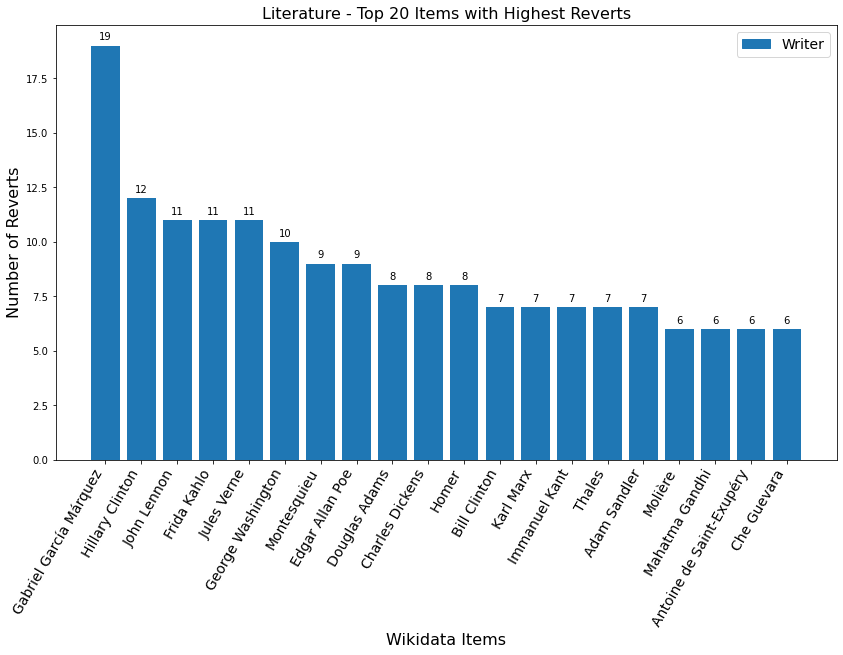

In [70]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.25, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

writer = mpatches.Patch(color='tab:blue', label='Writer')

plt.legend(handles=[writer], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Literature - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [71]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [72]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
987,Q9129,0,3,1,0,0,3,23,17
4788,Q3572191,0,2,0,0,0,0,7,3
8388,Q12953483,0,2,0,0,0,0,7,1
8447,Q13234758,0,2,0,1,0,12,34,12
8450,Q13360905,0,2,0,0,0,2,9,3
8747,Q16204856,0,2,0,0,0,1,8,3
9049,Q16944051,0,2,0,0,0,3,23,3
11078,Q3071880,0,2,0,0,0,4,8,1
11135,Q3091331,0,2,0,1,0,0,6,2
11376,Q3195346,0,2,0,0,0,0,10,2


In [73]:
merge_item_labels = ['Greek', 'Yerong', 'Swiss-French Sign Language', 'Andres Anvelt', 'Journal of Applied Mathematics and Mechanics',
                     'David Farrier', 'Chandler Rathfon Post', 'Ir', 'Fwâi', 'Ke\'o', 
                     'Japanese writing system', 'Abdul Aziz al-Harbi', 'Desiya', 'Wikinews article', 'Bert Van Kerkhoven', 
                     'Nage', 'Maksim Tank', 'Timonides of Leucas', 'Revista Española de Cardiología', 'Yuval Noah Harari']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [74]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
987,Q9129,Greek,0,3,1,0,0,3,23,17
4788,Q3572191,Yerong,0,2,0,0,0,0,7,3
8388,Q12953483,Swiss-French Sign Language,0,2,0,0,0,0,7,1
8447,Q13234758,Andres Anvelt,0,2,0,1,0,12,34,12
8450,Q13360905,Journal of Applied Mathematics and Mechanics,0,2,0,0,0,2,9,3
8747,Q16204856,David Farrier,0,2,0,0,0,1,8,3
9049,Q16944051,Chandler Rathfon Post,0,2,0,0,0,3,23,3
11078,Q3071880,Ir,0,2,0,0,0,4,8,1
11135,Q3091331,Fwâi,0,2,0,1,0,0,6,2
11376,Q3195346,Ke'o,0,2,0,0,0,0,10,2


Text(0.5, 1.0, 'Literature - Top 20 Items with Highest Merges')

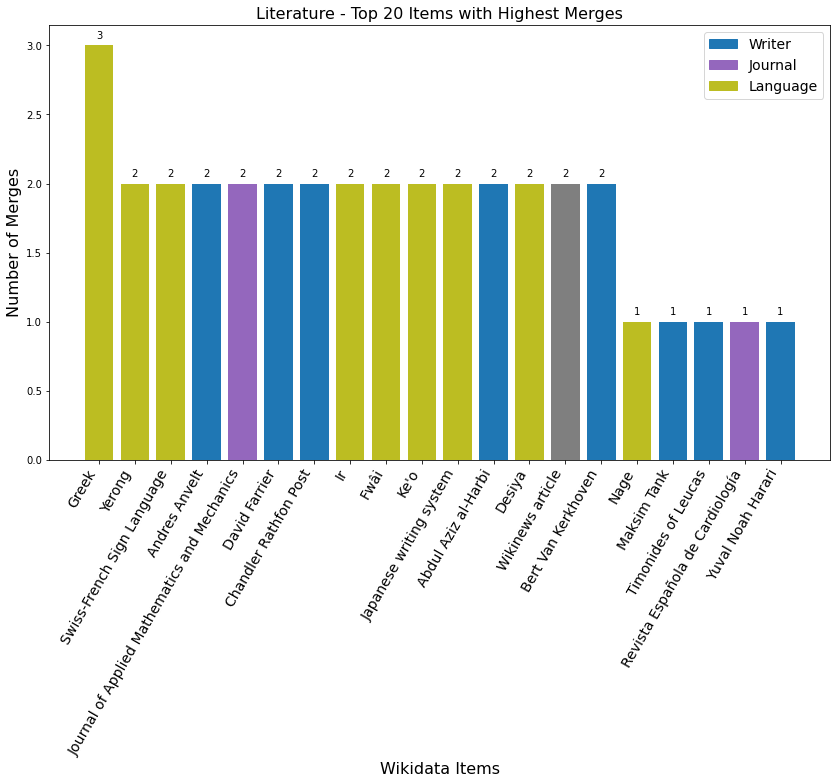

In [75]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:olive', 'tab:olive', 'tab:olive', 'tab:blue', 'tab:purple',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:olive', 'tab:olive',
           'tab:olive', 'tab:blue', 'tab:olive', 'tab:gray', 'tab:blue',
           'tab:olive', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:blue']

writer = mpatches.Patch(color='tab:blue', label='Writer')
journal = mpatches.Patch(color='tab:purple', label='Journal')
language = mpatches.Patch(color='tab:olive', label='Language')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[writer, journal, language], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Literature - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [76]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [77]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
1996,Q80938,0,1,31,0,0,6,114,17
1154,Q22686,5,1,19,2,0,28,456,122
1050,Q11256,5,1,16,0,0,7,164,51
12805,Q368127,0,0,13,1,0,1,49,15
3671,Q720581,0,0,12,0,0,2,25,12
12963,Q433210,1,0,11,1,1,10,109,27
12198,Q276181,0,0,10,0,0,3,20,7
841,Q1860,2,0,8,2,0,3,66,31
13960,Q1075796,0,0,8,0,0,1,12,4
1206,Q28975,0,0,7,0,0,1,17,7


In [78]:
undo_item_labels = ['John Travolta', 'Donald Trump', 'Fidel Castro', 'Elena Ferrante', 'Paul Reubens',
                     'Rita Barberá Nolla', 'Jim Varney', 'English', 'Carlos Alazraqui', 'Christopher Marlowe', 
                     'Douglas Adams', 'Julio Cortázar', 'Aisha Abd al-Rahman', 'Steve Harvey', 'Laury Thilleman', 
                     'Mahatma Gandhi', 'Carrie Fisher', 'Fred Rogers', 'Carolina Sanín Paz', 'Abraham Cahan']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [79]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
1996,Q80938,John Travolta,0,1,31,0,0,6,114,17
1154,Q22686,Donald Trump,5,1,19,2,0,28,456,122
1050,Q11256,Fidel Castro,5,1,16,0,0,7,164,51
12805,Q368127,Elena Ferrante,0,0,13,1,0,1,49,15
3671,Q720581,Paul Reubens,0,0,12,0,0,2,25,12
12963,Q433210,Rita Barberá Nolla,1,0,11,1,1,10,109,27
12198,Q276181,Jim Varney,0,0,10,0,0,3,20,7
841,Q1860,English,2,0,8,2,0,3,66,31
13960,Q1075796,Carlos Alazraqui,0,0,8,0,0,1,12,4
1206,Q28975,Christopher Marlowe,0,0,7,0,0,1,17,7


Text(0.5, 1.0, 'Literature - Top 20 Items with Highest Undos')

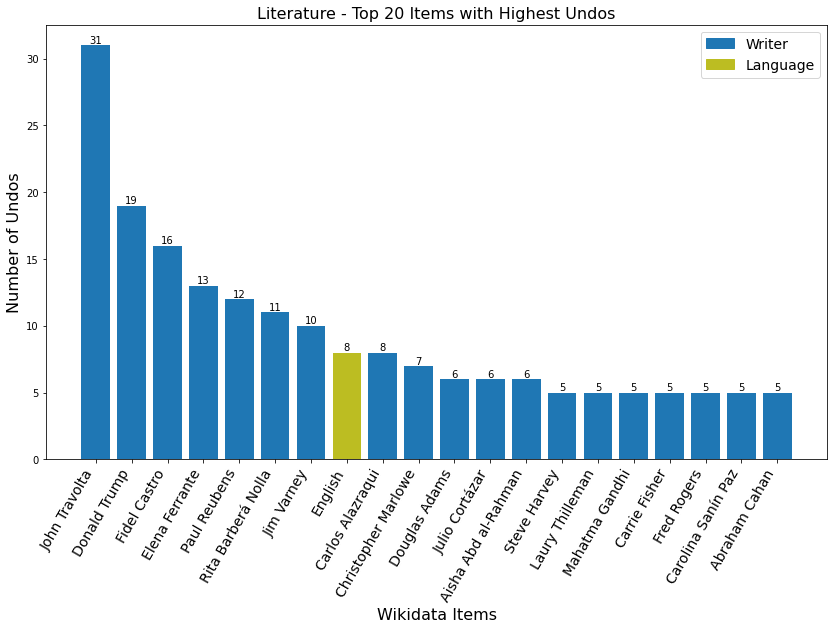

In [81]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.15, str(r), horizontalalignment='center')
    
colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

writer = mpatches.Patch(color='tab:blue', label='Writer')
language = mpatches.Patch(color='tab:olive', label='Language')

plt.legend(handles=[writer, language], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Literature - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [82]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [83]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
904,Q6294,12,0,3,8,0,14,199,52
758,Q42,8,0,6,6,1,11,78,23
6306,Q5753276,2,0,5,6,2,16,147,11
1121,Q16864,2,0,0,5,1,1,26,11
11623,Q203715,1,0,0,5,1,2,28,5
804,Q1001,6,0,5,4,0,1,78,27
898,Q5878,19,0,3,4,0,0,74,9
1116,Q16285,1,0,1,4,0,1,19,5
1122,Q16867,9,0,4,4,0,2,74,19
805,Q1035,0,0,0,3,0,0,29,16


In [84]:
restore_item_labels = ['Hillary Clinton', 'Douglas Adams', 'Carolina Sanín Paz', 'Horacio Quiroga', 'Gustavo Adolfo Bécquer',
                     'Mahatma Gandhi', 'Gabriel García Márquez', 'Mario Benedetti ', 'Edgar Allan Poe', 'Charles Darwin', 
                     'Jean-Jacques Rousseau', 'Karl Marx', 'Montesquieu', 'Euripides', 'Jordi de Manuel', 
                     'Susie Taylor', 'José Hernández', 'Anna Kingsford', 'Nicolaus Copernicus', 'Dario Fo']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [85]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
904,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
758,Q42,Douglas Adams,8,0,6,6,1,11,78,23
6306,Q5753276,Carolina Sanín Paz,2,0,5,6,2,16,147,11
1121,Q16864,Horacio Quiroga,2,0,0,5,1,1,26,11
11623,Q203715,Gustavo Adolfo Bécquer,1,0,0,5,1,2,28,5
804,Q1001,Mahatma Gandhi,6,0,5,4,0,1,78,27
898,Q5878,Gabriel García Márquez,19,0,3,4,0,0,74,9
1116,Q16285,Mario Benedetti,1,0,1,4,0,1,19,5
1122,Q16867,Edgar Allan Poe,9,0,4,4,0,2,74,19
805,Q1035,Charles Darwin,0,0,0,3,0,0,29,16


Text(0.5, 1.0, 'Literature - Top 20 Items with Highest Restores')

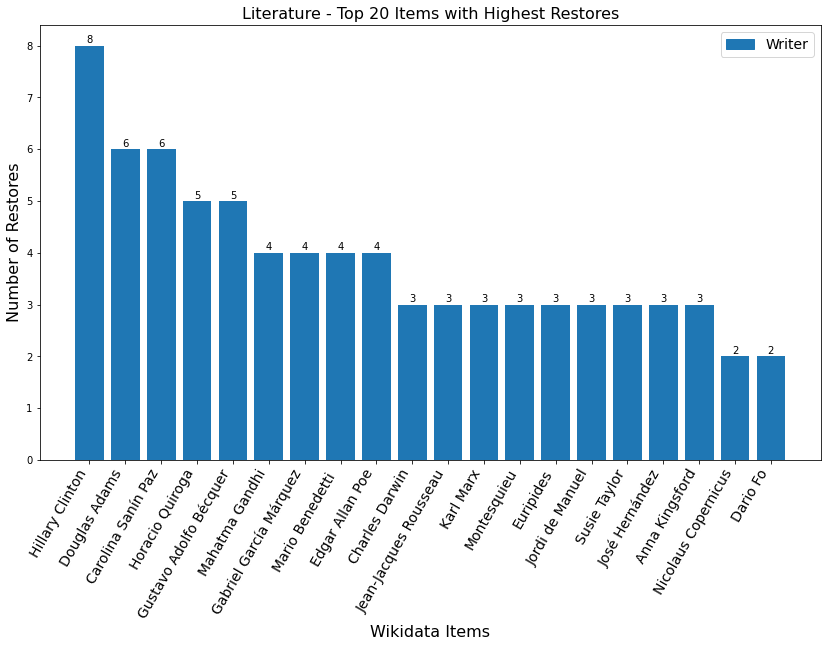

In [86]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']

writer = mpatches.Patch(color='tab:blue', label='Writer')

plt.legend(handles=[writer], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Literature - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [87]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [88]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
1154,Q22686,5,1,19,2,0,28,456,122
1204,Q28614,0,0,0,1,0,5,338,12
1780,Q68610,0,0,0,1,0,4,326,9
1831,Q72473,0,0,0,1,0,2,317,7
2112,Q89517,0,0,0,1,0,1,317,6
12807,Q368696,0,0,0,1,0,3,317,8
1796,Q69936,0,0,0,1,0,2,315,5
4087,Q1366865,0,1,0,0,0,0,312,3
1850,Q73636,0,0,0,1,0,0,310,4
1769,Q67757,0,0,2,0,0,1,229,6


In [89]:
edit_item_labels = ['Donald Trump', 'Garry Kasparov', 'Thomas Luther', 'Lev Gutman', 'Raj Tischbierek',
                     'Jouni Yrjölä', 'Karsten Müller', 'Ivar Bern', 'Karel van der Weide', 'Rudolf Teschner', 
                     'Hillary Clinton', 'Debbie Reynolds', 'Fidel Castro', 'Carolina Sanín Paz', 'Carrie Fisher',  
                     'Laura Mancinelli', 'John Travolta', 'Mathematica', 'Rita Barberá Nolla', 'Leonard Cohen']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [90]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
1154,Q22686,Donald Trump,5,1,19,2,0,28,456,122
1204,Q28614,Garry Kasparov,0,0,0,1,0,5,338,12
1780,Q68610,Thomas Luther,0,0,0,1,0,4,326,9
1831,Q72473,Lev Gutman,0,0,0,1,0,2,317,7
2112,Q89517,Raj Tischbierek,0,0,0,1,0,1,317,6
12807,Q368696,Jouni Yrjölä,0,0,0,1,0,3,317,8
1796,Q69936,Karsten Müller,0,0,0,1,0,2,315,5
4087,Q1366865,Ivar Bern,0,1,0,0,0,0,312,3
1850,Q73636,Karel van der Weide,0,0,0,1,0,0,310,4
1769,Q67757,Rudolf Teschner,0,0,2,0,0,1,229,6


Text(0.5, 1.0, 'Literature - Top 20 Items with Highest Edits')

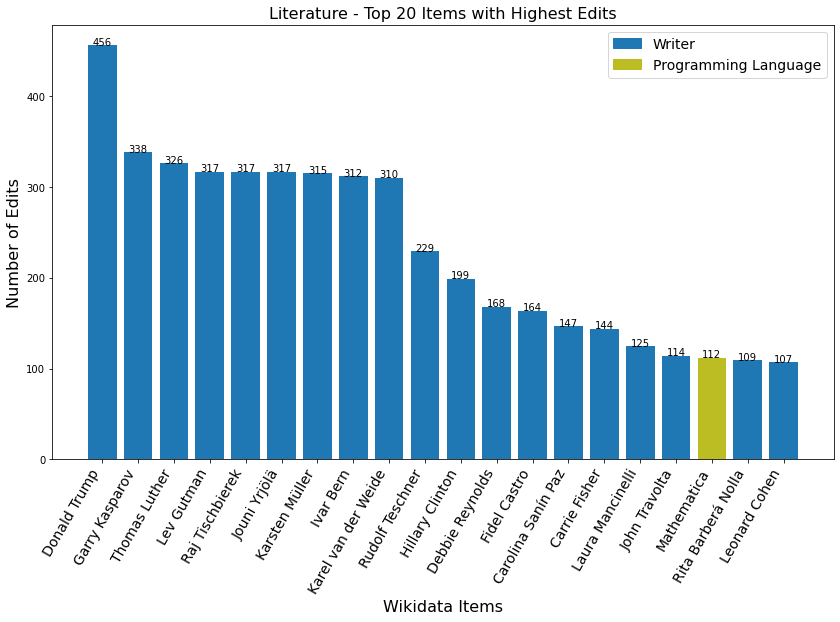

In [91]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue']

writer = mpatches.Patch(color='tab:blue', label='Writer')
language = mpatches.Patch(color='tab:olive', label='Programming Language')

plt.legend(handles=[writer, language], fontsize=14)


plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Literature - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [92]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [93]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
1154,Q22686,5,1,19,2,0,28,456,122
3207,Q548733,0,1,1,0,0,4,93,55
904,Q6294,12,0,3,8,0,14,199,52
2381,Q108941,0,0,5,0,0,6,144,52
818,Q1276,0,0,2,0,0,4,107,51
1050,Q11256,5,1,16,0,0,7,164,51
769,Q392,1,0,1,1,0,6,84,50
1619,Q57311,4,0,3,1,0,5,100,44
12088,Q263696,0,0,1,0,1,17,168,44
13953,Q1071031,0,0,0,1,0,1,97,38


In [94]:
user_item_labels = ['Donald Trump', 'Vajiralongkorn I of Thailand', 'Hillary Clinton', 'Carrie Fisher', 'Leonard Cohen',
                     'Fidel Castro', 'Bob Dylan', 'Juan Manuel Santos', 'Debbie Reynolds', 'Paolo Gentiloni', 
                     'Ivanka Trump', 'Laura Mancinelli', 'English', 'Mahatma Gandhi', 'Rita Barberá Nolla',  
                     'Joseph Stalin', 'Spanish', 'Ivana Trump', 'Douglas Adams', 'Albert Einstein']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [95]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
1154,Q22686,Donald Trump,5,1,19,2,0,28,456,122
3207,Q548733,Vajiralongkorn I of Thailand,0,1,1,0,0,4,93,55
904,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
2381,Q108941,Carrie Fisher,0,0,5,0,0,6,144,52
818,Q1276,Leonard Cohen,0,0,2,0,0,4,107,51
1050,Q11256,Fidel Castro,5,1,16,0,0,7,164,51
769,Q392,Bob Dylan,1,0,1,1,0,6,84,50
1619,Q57311,Juan Manuel Santos,4,0,3,1,0,5,100,44
12088,Q263696,Debbie Reynolds,0,0,1,0,1,17,168,44
13953,Q1071031,Paolo Gentiloni,0,0,0,1,0,1,97,38


Text(0.5, 1.0, 'Literature - Top 20 Items with Highest Users')

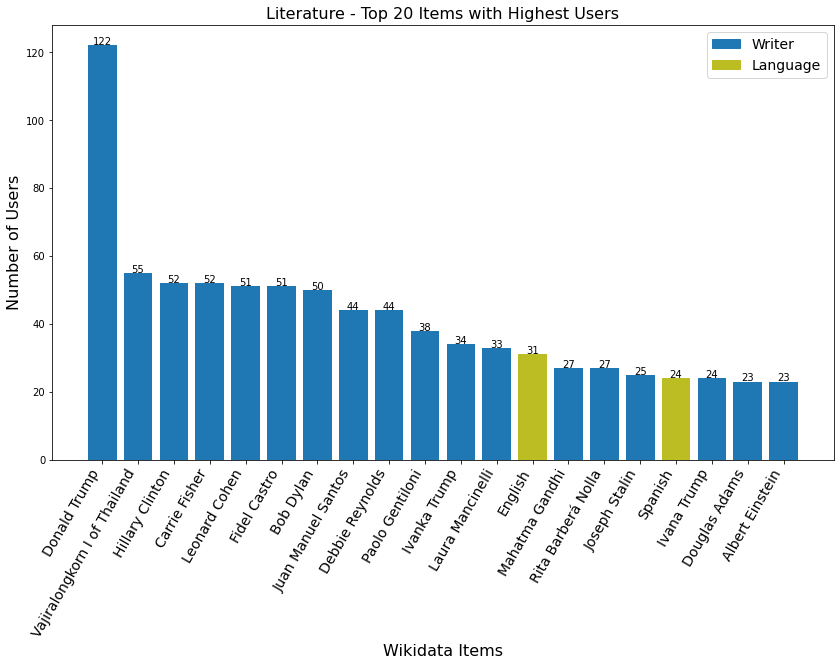

In [96]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.15, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue', 'tab:blue']

writer = mpatches.Patch(color='tab:blue', label='Writer')
language = mpatches.Patch(color='tab:olive', label='Language')

plt.legend(handles=[writer, language], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Literature - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [97]:
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [98]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print(common_20)

Q1001        4
Q42          4
Q6294        4
Q22686       3
Q11256       3
Q108941      3
Q5753276     3
Q433210      3
Q3827806     2
Q263696      2
Q1860        2
Q15975       2
Q16867       2
Q80938       2
Q9061        2
Q5878        2
Q1276        2
Q23581907    1
Q2434987     1
Q16944051    1
Name: qid, dtype: int64


Most of the items in this topic had been seen before, ex in politics.

- Q1860	English
- Q108941 Carrie Fisher

In [100]:
# Storing the revisions of the selected items in CSV files
# rev[rev['qid'] == 'Q108941'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/literature/CarrieFisher_Q108941.csv')
# rev[rev['qid'] == 'Q1860'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/literature/English_Q1860.csv')